*

---

# Setup

##### Set Root Dir as CWD

In [1]:
import os

# Navigate to project root (if not already there)
if os.path.split(os.getcwd())[1] != "cs374-project":
    %cd ../

D:\Documents\A_DIGIPEN\PersonalSVN\Fall22SVN\CS374\Project\cs374-project


##### Imports

In [2]:
import numpy as np
import pandas as pd

import spacy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Local
from src.preprocesser import ReviewPreprocessor
from src.model import ReviewClassifier

##### Other Setup

In [3]:
proto_num = 5

# Load

In [4]:
path = "data/yelp/reviews/"

In [5]:
%%time
# Load dev set (10% of total data) as train
train_all = pd.read_pickle(path + "train.xz")

CPU times: total: 30.7 s
Wall time: 30.8 s


In [6]:
%%time
# Load test set (10% of total data) as test
test_all = pd.read_pickle(path + "test.xz")

CPU times: total: 3.97 s
Wall time: 4.03 s


In [8]:
#num_samples = (10_000, 10_000)

train = train_all.iloc[:] #num_samples[0]]
test = test_all.iloc[:] #num_samples[1]]

In [9]:
train

,text,stars
2903612,I like Wedding Belles for an odd reason. I set...,5
5050964,We had a great stay here. I felt like we got a...,5
1226557,"A unique place for sure, not your standard bre...",3
776083,This will be a short review on service and gri...,4
227582,Great barbershop. Super friendly staff. They a...,5
...,...,...
3578067,I've not personally had the bad experiences th...,4
424533,Dive bar.\nNew ownership has improved the menu...,3
28275,"This place is so addicting, good vegan options...",5
2949771,"What is not to love about Wingfield Park, down...",5


##### Save Target

In [10]:
# Save reviews stars from 0-4
y_train = tf.convert_to_tensor(train["stars"].values - 1)
y_test = tf.convert_to_tensor(test["stars"].values - 1)

# Preprocess

In [11]:
batch_size = 8000
n_processes = 2

maxlen = 200         # Number of words per review to consider
vocab_size = 20_000  # Size of vocabulary

##### Load from raw data

> Preprocess from scratch. Takes a long time!

In [12]:
%%time
# Configure preprocessor
prep = ReviewPreprocessor(vocab_size, maxlen)

# Preprocess text
X_train_norm = prep.normalize(train["text"], batch_size, n_processes)
X_test_norm = prep.normalize(test["text"], batch_size, n_processes)

# Fit tokenizer
prep.fit_tokenizer(X_train_norm)

# Convert to tensor of padded sequences
X_train = prep.to_tensor(X_train_norm)
X_test = prep.to_tensor(X_test_norm)

CPU times: total: 1h 11min 52s
Wall time: 3h 55s


In [13]:
%%time
# Save results
pd.Series(X_train_norm).to_pickle(path + "train_prep.xz")
pd.Series(X_test_norm).to_pickle(path + "test_prep.xz")
prep.save_as_pickle(f"prototypes/preprocessors/prep_v{proto_num}.pickle")

CPU times: total: 23min 42s
Wall time: 23min 48s


##### Load already preprocessed data

> Load already preprocessed data. Takes a bit.

In [23]:
%%time
# Load preprocessed
X_train_norm = pd.read_pickle(path + "train_prep.xz")
X_test_norm = pd.read_pickle(path + "test_prep.xz")

# Load preprocessor
prep = ReviewPreprocessor.load_from_pickle(f"prototypes/preprocessors/prep_v{proto_num}.pickle")

# Convert to tensor of padded sequences
X_train = prep.to_tensor(X_train_norm)
X_test = prep.to_tensor(X_test_norm)

CPU times: total: 3min 45s
Wall time: 3min 52s


##### View Before and After Preprocessing

In [14]:
print_idx = 8
print(test["text"].iloc[print_idx])
print("\n - - - - \n")
print(X_test_norm[print_idx], len(X_test_norm[print_idx]))
print("\n - - - - \n")
print(X_test[print_idx])

Ordered through grub hub, food came half an hour past the maximum delivery window. A simple breakfast order took 90 minutes to get to me, and the potatoes were half raw. Delivery timing may not have been the restaurant's fault, but the undercooked food was.

Delivery fee is actually $3.99, NOT $0 as posted on yelp

 - - - - 

['order', 'grub', 'hub', ',', 'food', 'come', 'TIME', 'TIME', 'TIME', 'past', 'maximum', 'delivery', 'window', '.', 'simple', 'breakfast', 'order', 'take', '90', 'e0', 'TIME', ',', 'potato', 'CARDINAL', 'raw', '.', 'delivery', 'timing', 'restaurant', "'", 's', 'fault', ',', 'undercooked', 'food', '.', 'delivery', 'fee', 'actually', '$', '3', 'e0', '.', '99', 'e0', ',', '$', '0', 'e0', 'post', 'yelp'] 51

 - - - - 

tf.Tensor(
[  20 2793 2647    2   14   22    6    6    6  587 5661  422  502    1
  501  168   20   52 1269    9    6    2  261   17  964    1  422 2764
   36    3   12 1104    2 1781   14    1  422  762  210   59   99    9
    1  968    9    2   59 135

# Model

* Reference https://keras.io/examples/nlp/text_classification_with_transformer/

##### Create Model

In [45]:
# Hyperparameters
embed_dim = 64  # Attention output size
num_heads = 4   # Number of attention heads
ff_dims = [64]  # Hidden layer sizes in feed forward network inside transformer
reg = 1.0e-2
dropout = 0.3

# Model
model = ReviewClassifier(maxlen, vocab_size, embed_dim, num_heads, ff_dims, reg, dropout)

In [46]:
model.predict(X_train[:5])

1/1 [==============================] - 0s 137ms/step


array([[0.18876582, 0.17075287, 0.14851785, 0.21231705, 0.27964646],
       [0.19918841, 0.15933062, 0.12013217, 0.20183653, 0.3195123 ],
       [0.19731154, 0.13854395, 0.13348816, 0.19305576, 0.33760062],
       [0.18663318, 0.16710761, 0.13357888, 0.20507845, 0.3076018 ],
       [0.21252346, 0.14143308, 0.127633  , 0.19168882, 0.3267217 ]],
      dtype=float32)

##### Compile and Run

In [47]:
learning_rate = 1e-3

model.compile(optimizer=keras.optimizers.Adam(learning_rate), 
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.build(X_train.shape)

In [48]:
model.summary()

Model: "review_classifier_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 t_emb (Embedding)           multiple                  1280000   
                                                                 
 p_emb (Embedding)           multiple                  12800     
                                                                 
 attention (MultiHeadAttenti  multiple                 66368     
 on)                                                             
                                                                 
 sequential_6 (Sequential)   (None, 200, 64)           4160      
                                                                 
 layer_normalization_12 (Lay  multiple                 128       
 erNormalization)                                                
                                                                 
 layer_normalization_13 (Lay  multiple         

In [49]:
%%time
# Train model
epochs = 20
cp_path = "prototypes/model_checkpoints/"
cp_num = 5

# Early stopping 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Create a callback that saves the model's weights
checkpoint_dir = os.path.dirname(cp_path)
create_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=cp_path + f"refactor{cp_num}.ckpt", monitor="val_loss", verbose=1, save_best_only=True)

history = model.fit(
    X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test),
    callbacks=[early_stopping, create_checkpoint], verbose=1,
)

Epoch 1/20
174756/174757 [============================>.] - ETA: 0s - loss: 0.7891 - accuracy: 0.6760
Epoch 1: val_loss improved from inf to 0.74224, saving model to prototypes/model_checkpoints\refactor5.ckpt


INFO:tensorflow:Assets written to: prototypes/model_checkpoints\refactor5.ckpt\assets


INFO:tensorflow:Assets written to: prototypes/model_checkpoints\refactor5.ckpt\assets


174757/174757 [==============================] - 777s 4ms/step - loss: 0.7891 - accuracy: 0.6760 - val_loss: 0.7422 - val_accuracy: 0.6894
Epoch 2/20
174756/174757 [============================>.] - ETA: 0s - loss: 0.7608 - accuracy: 0.6863
Epoch 2: val_loss improved from 0.74224 to 0.73651, saving model to prototypes/model_checkpoints\refactor5.ckpt


INFO:tensorflow:Assets written to: prototypes/model_checkpoints\refactor5.ckpt\assets


INFO:tensorflow:Assets written to: prototypes/model_checkpoints\refactor5.ckpt\assets


174757/174757 [==============================] - 779s 4ms/step - loss: 0.7607 - accuracy: 0.6863 - val_loss: 0.7365 - val_accuracy: 0.6914
Epoch 3/20
174747/174757 [============================>.] - ETA: 0s - loss: 0.7524 - accuracy: 0.6899
Epoch 3: val_loss improved from 0.73651 to 0.73370, saving model to prototypes/model_checkpoints\refactor5.ckpt


INFO:tensorflow:Assets written to: prototypes/model_checkpoints\refactor5.ckpt\assets


INFO:tensorflow:Assets written to: prototypes/model_checkpoints\refactor5.ckpt\assets


174757/174757 [==============================] - 786s 4ms/step - loss: 0.7524 - accuracy: 0.6899 - val_loss: 0.7337 - val_accuracy: 0.6937
Epoch 4/20
174753/174757 [============================>.] - ETA: 0s - loss: 0.7483 - accuracy: 0.6920
Epoch 4: val_loss did not improve from 0.73370
174757/174757 [==============================] - 780s 4ms/step - loss: 0.7483 - accuracy: 0.6920 - val_loss: 0.7372 - val_accuracy: 0.6925
Epoch 5/20
174757/174757 [==============================] - ETA: 0s - loss: 0.7461 - accuracy: 0.6927
Epoch 5: val_loss improved from 0.73370 to 0.73329, saving model to prototypes/model_checkpoints\refactor5.ckpt


INFO:tensorflow:Assets written to: prototypes/model_checkpoints\refactor5.ckpt\assets


INFO:tensorflow:Assets written to: prototypes/model_checkpoints\refactor5.ckpt\assets


174757/174757 [==============================] - 768s 4ms/step - loss: 0.7461 - accuracy: 0.6927 - val_loss: 0.7333 - val_accuracy: 0.6928
Epoch 6/20
174747/174757 [============================>.] - ETA: 0s - loss: 0.7445 - accuracy: 0.6935
Epoch 6: val_loss did not improve from 0.73329
174757/174757 [==============================] - 762s 4ms/step - loss: 0.7445 - accuracy: 0.6935 - val_loss: 0.7336 - val_accuracy: 0.6944
Epoch 7/20
174745/174757 [============================>.] - ETA: 0s - loss: 0.7437 - accuracy: 0.6938
Epoch 7: val_loss improved from 0.73329 to 0.73073, saving model to prototypes/model_checkpoints\refactor5.ckpt


INFO:tensorflow:Assets written to: prototypes/model_checkpoints\refactor5.ckpt\assets


INFO:tensorflow:Assets written to: prototypes/model_checkpoints\refactor5.ckpt\assets


174757/174757 [==============================] - 765s 4ms/step - loss: 0.7437 - accuracy: 0.6938 - val_loss: 0.7307 - val_accuracy: 0.6930
Epoch 8/20
174753/174757 [============================>.] - ETA: 0s - loss: 0.7431 - accuracy: 0.6941
Epoch 8: val_loss did not improve from 0.73073
174757/174757 [==============================] - 765s 4ms/step - loss: 0.7431 - accuracy: 0.6941 - val_loss: 0.7343 - val_accuracy: 0.6928
Epoch 9/20
174747/174757 [============================>.] - ETA: 0s - loss: 0.7427 - accuracy: 0.6941
Epoch 9: val_loss did not improve from 0.73073
174757/174757 [==============================] - 767s 4ms/step - loss: 0.7427 - accuracy: 0.6941 - val_loss: 0.7353 - val_accuracy: 0.6921
Epoch 10/20
174748/174757 [============================>.] - ETA: 0s - loss: 0.7424 - accuracy: 0.6943
Epoch 10: val_loss did not improve from 0.73073
174757/174757 [==============================] - 751s 4ms/step - loss: 0.7424 - accuracy: 0.6943 - val_loss: 0.7344 - val_accuracy: 0.

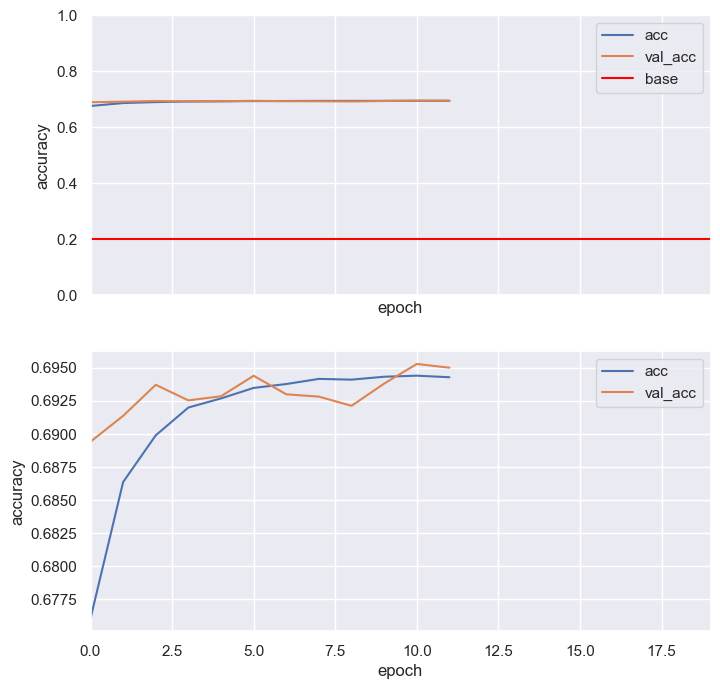

In [50]:
hist = history.history
acc, val_acc = hist["accuracy"], hist["val_accuracy"]

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8), dpi=100)

for i, ax in enumerate(axes):
    ax.plot(acc, label="acc")
    ax.plot(val_acc, label="val_acc")
    
    ax.set_xlim(0, epochs - 1)
    if i == 0:
        ax.set_ylim(0.0, 1.0)
        ax.axhline(0.2, color="red", label="base")
        
    ax.grid(visible=True, axis="both")
    ax.legend()
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")

plt.show()

##### Evaluate

In [51]:
# Get probabilities per class
y_pred = model.predict(X_test)

21845/21845 [==============================] - 36s 2ms/step


In [52]:
# Get star predictions and negative/positive predictions
y_pred_multi = tf.argmax(y_pred, axis=1)

In [53]:
# Calculate continuous star rating based on probabilities
star_reg = tf.reduce_sum(y_pred * np.array([0, 1, 2, 3, 4]), axis=1)
star_reg

<tf.Tensor: shape=(699028,), dtype=float64, numpy=
array([3.91745288, 3.82218743, 0.09109641, ..., 3.96920484, 3.10105394,
       3.89718001])>

In [54]:
# Determine if sentiment is negative or postiive
y_pred_binary = star_reg > 2

In [55]:
print("multi-class accuracy: " + str((y_pred_multi == y_test).numpy().sum() / len(y_test)))
print("(compare to ~0.2)")

multi-class accuracy: 0.6949950502698032
(compare to ~0.2)


In [56]:
print("binary accuracy: " + str((y_pred_binary == (y_test >= 3)).numpy().sum() / len(y_test)))
print("(compare to ~0.5)")

binary accuracy: 0.9059236539881093
(compare to ~0.5)


In [57]:
avg_err = tf.reduce_sum(tf.math.abs(y_test - y_pred_multi)) / len(y_test)
avg_err = avg_err.numpy()
print(f"Average of {avg_err:.4f} stars off")

Average of 0.3809 stars off


##### Visualize Attention

In [58]:
# Get attention scores
_, attns = model(X_test[:100], return_att=True)

# Get attention for each sample
attns = tf.reduce_mean(attns, axis=2)[:, 0, :]
attns

<tf.Tensor: shape=(100, 200), dtype=float32, numpy=
array([[0.04983199, 0.        , 0.03516538, ..., 0.        , 0.        ,
        0.        ],
       [0.00950472, 0.20049529, 0.005     , ..., 0.        , 0.        ,
        0.        ],
       [0.07      , 0.27999842, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.025     , 0.08984116, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.005     , 0.03      , 0.07      , ..., 0.        , 0.        ,
        0.        ],
       [0.135     , 0.17285107, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [59]:
attns[0][:34]

<tf.Tensor: shape=(34,), dtype=float32, numpy=
array([4.98319902e-02, 0.00000000e+00, 3.51653807e-02, 5.75425662e-02,
       1.99999996e-02, 1.98365208e-02, 3.50033864e-02, 0.00000000e+00,
       1.99999996e-02, 0.00000000e+00, 0.00000000e+00, 9.99999978e-03,
       0.00000000e+00, 0.00000000e+00, 4.99999989e-03, 0.00000000e+00,
       0.00000000e+00, 6.46237913e-06, 0.00000000e+00, 9.99999978e-03,
       6.28405600e-04, 0.00000000e+00, 3.43715958e-02, 0.00000000e+00,
       3.89999241e-01, 0.00000000e+00, 2.74574328e-02, 0.00000000e+00,
       9.99999978e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00017525e-02, 1.50034457e-01], dtype=float32)>

<Original Text>
This place is NOT closed.  We went there on 18 August 2017.  Great, great corned beef and pastrami sandwich, the Bains special.  Also wonderful Italian sub and tuna sandwich.  Our picky son, who eats nothing, actually ate a third of his sister's sandwich.  One of the best lunches we've had in a long time.  Really nice staff and not a bad price.

<Preprocessed>
['place', 'close', 'go', '18', 'e0', 'date', '20', 'e2', 'great', 'great', 'corned', 'beef', 'pastrami', 'sandwich', 'norp', 'special', 'wonderful', 'norp', 'sub', 'tuna', 'sandwich', 'picky', 'son', 'eat', 'actually', 'eat', 'ordinal', 'sister', "'", 's', 'sandwich', 'cardinal', 'good', 'lunch', "'", 've', 'long', 'time', 'nice', 'staff', 'bad', 'price']


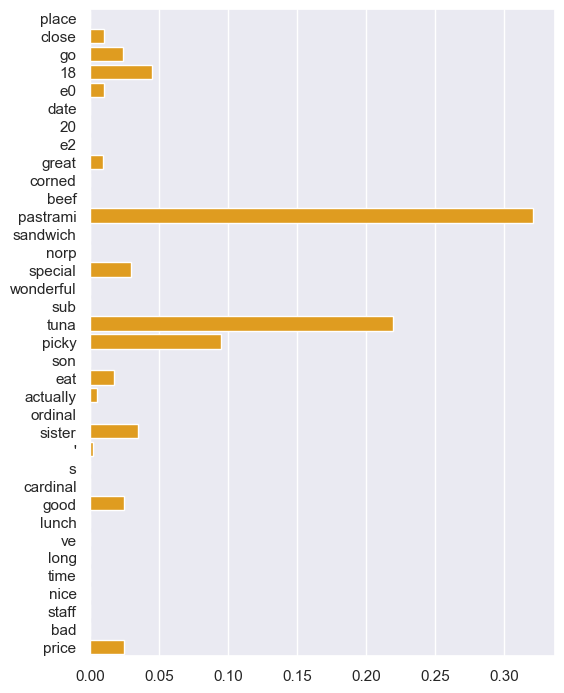

In [66]:
sample_idx = 6

# Get word sequences without oov words
in_seq = X_test_norm[sample_idx]
in_seq = [tok for tok in prep.tokenizer.sequences_to_texts(prep.tokenizer.texts_to_sequences(in_seq)) if tok]
seq_len = len(in_seq)

# Get attention values
attn_vals = attns[sample_idx][:seq_len].numpy()

print("<Original Text>")
print(test["text"].iloc[sample_idx])

print("\n<Preprocessed>")
print(in_seq)

plt.figure(figsize=(6, 0.2 * seq_len), dpi=100)
sns.barplot(y=in_seq, x=attn_vals, ci=None, color="orange")

plt.show()